# Load Libraries

In [3]:
import pandas as pd
import numpy as np
import random
import os
import datetime

# 시각화 패키지 불러오기
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# font
plt.rc('font', family='AppleGothic')

# machine learning
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier



# Fixed Random Seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# Load Dataset

In [5]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

display(train_df.head(3))
display(test_df.head(3))

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A


,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,TEST_00000,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,TEST_00001,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,TEST_00002,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0


# 데이터 전처리 1 : 학습 및 추론 데이터 설정¶

모델에게 입력할 학습 데이터와 추론 데이터를 만들어 봅시다



In [6]:
train_x = train_df.drop(columns=['ID', '대출등급'])
train_y = train_df['대출등급']

test_x = test_df.drop(columns=['ID'])

# Visualization

In [7]:
train_df.columns

Index(['ID', '대출금액', '대출기간', '근로기간', '주택소유상태', '연간소득', '부채_대비_소득_비율', '총계좌수',
       '대출목적', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '대출등급'],
      dtype='object')

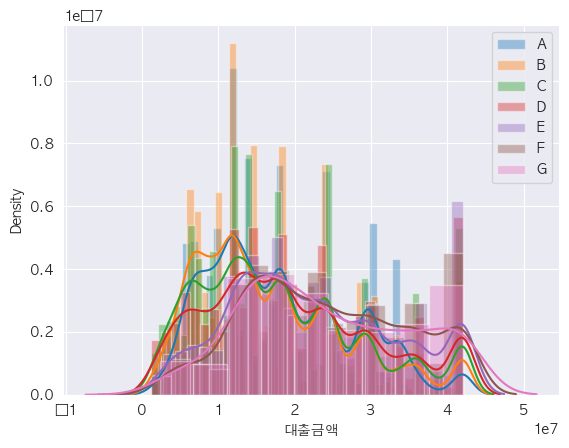

In [8]:
sns.distplot(train_df['대출금액'].loc[train_df['대출등급']=='A'], label='A')
sns.distplot(train_df['대출금액'].loc[train_df['대출등급']=='B'], label='B')
sns.distplot(train_df['대출금액'].loc[train_df['대출등급']=='C'], label='C')
sns.distplot(train_df['대출금액'].loc[train_df['대출등급']=='D'], label='D')
sns.distplot(train_df['대출금액'].loc[train_df['대출등급']=='E'], label='E')
sns.distplot(train_df['대출금액'].loc[train_df['대출등급']=='F'], label='F')
sns.distplot(train_df['대출금액'].loc[train_df['대출등급']=='G'], label='G')
plt.legend()
plt.show()

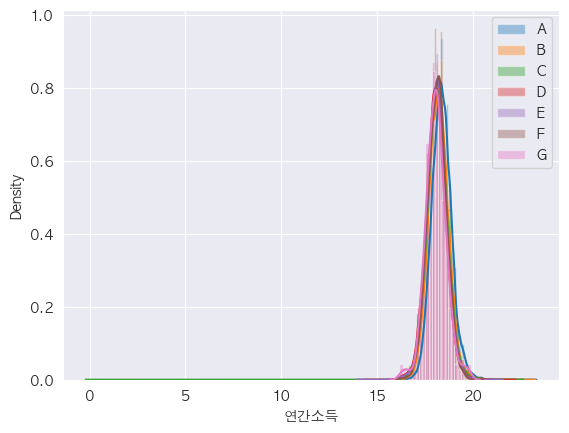

In [9]:
sns.distplot(np.log1p(train_df['연간소득'].loc[train_df['대출등급']=='A']), label='A')
sns.distplot(np.log1p(train_df['연간소득'].loc[train_df['대출등급']=='B']), label='B')
sns.distplot(np.log1p(train_df['연간소득'].loc[train_df['대출등급']=='C']), label='C')
sns.distplot(np.log1p(train_df['연간소득'].loc[train_df['대출등급']=='D']), label='D')
sns.distplot(np.log1p(train_df['연간소득'].loc[train_df['대출등급']=='E']), label='E')
sns.distplot(np.log1p(train_df['연간소득'].loc[train_df['대출등급']=='F']), label='F')
sns.distplot(np.log1p(train_df['연간소득'].loc[train_df['대출등급']=='G']), label='G')
plt.legend()
plt.show()

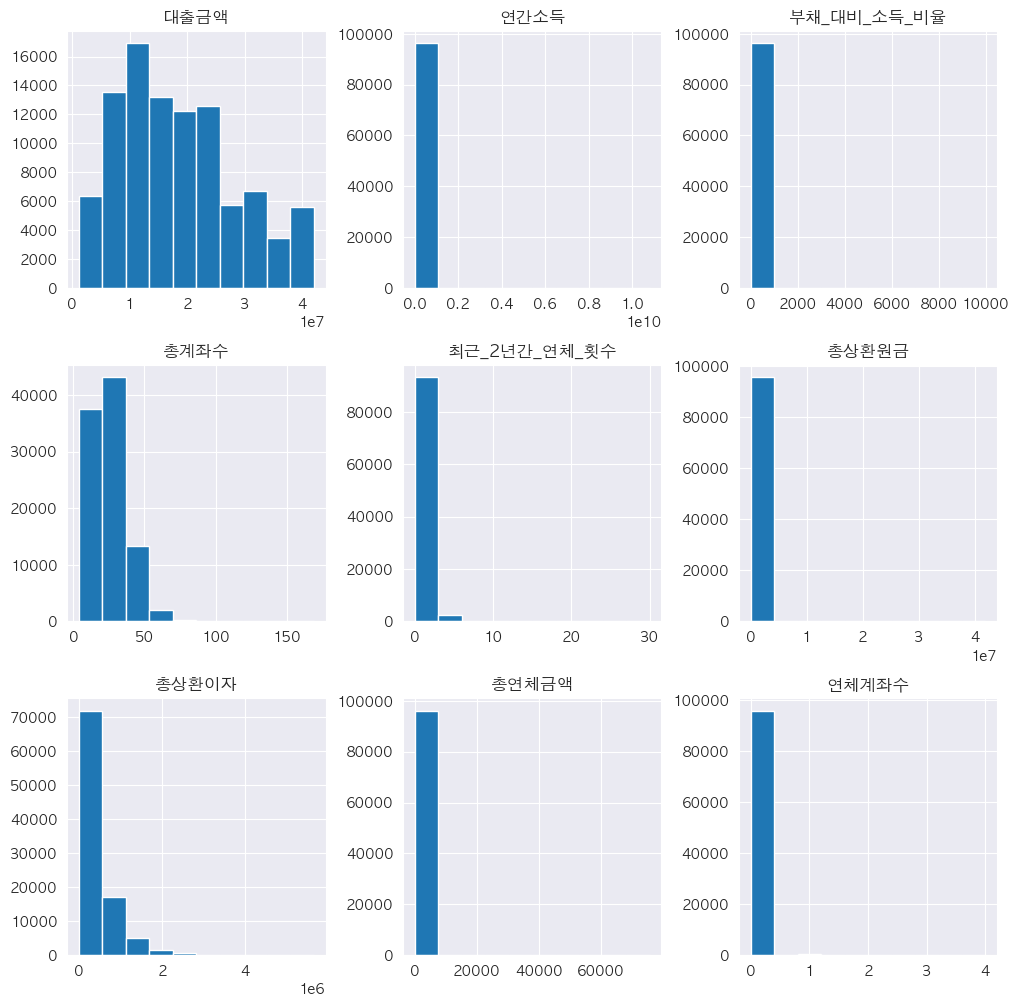

In [10]:
# 전체 데이터 훑어보기
target = train_x.hist(figsize=(12,12))
plt.show()

# 데이터 전처리 2-1 : 범주형 변수 수치화 (근로기간, 대출기간)¶

#### LabelEncoder를 통해 범주형 변수 수치화 진행

In [11]:
# '근로기간' 컬럼 데이터 매핑
mapping = {
    '6 years': 6,
    '10+ years': 10,
    '5 years': 5,
    '8 years': 8,
    'Unknown': 0,
    '9 years': 9,
    '2 years': 2,
    '1 year': 1,
    '3 years': 3,
    '7 years': 7
}

# '근로기간' 컬럼을 숫자로 변환
train_x['근로기간'] = train_x['근로기간'].map(mapping)
test_x['근로기간'] = test_x['근로기간'].map(mapping)

In [12]:
# 대출기간
train_x['대출기간'] = train_x['대출기간'].str.extract('(\d+)').astype(int)
test_x['대출기간'] = test_x['대출기간'].str.extract('(\d+)').astype(int)

# 데이터 전처리 2-2 : 범주형 변수 수치화¶

#### LabelEncoder를 통해 범주형 변수 수치화 진행

In [13]:
categorical_features = ['주택소유상태', '대출목적']

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_x[i]) 
    train_x[i]=le.transform(train_x[i])
    
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    test_x[i]=le.transform(test_x[i])

display(train_x.head(3))
display(test_x.head(3))

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,12480000,36,6.0,3,72000000,18.90,15,1,0,0,0.0,0.0,0.0
1,14400000,60,10.0,1,130800000,22.33,21,10,0,373572,234060.0,0.0,0.0
2,12000000,36,5.0,1,96000000,8.60,14,1,0,928644,151944.0,0.0,0.0


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,16800000,36,8.0,1,132000000,19.64,12,10,0,394692,146604.0,0.0,0.0
1,8400000,36,5.0,3,89971200,15.84,25,1,0,0,0.0,0.0,0.0
2,17280000,36,6.0,3,150000000,8.41,20,3,0,1786980,281820.0,0.0,0.0


# 데이터 전처리 3 : 수치형 변수 전처리

#### 

# 데이터 전처리 4 : 새로운 피쳐 생성

1. 연간소득 대비 대출금액 비율
2. 대출금액 대비 총상환원금+총상환이자
3. 총상환이자/총상환원금

In [14]:
# '연간소득'이 0인 경우를 NaN으로 대체
train_x['연간소득'] = train_x['연간소득'].replace(0, np.nan)
test_x['연간소득'] = test_x['연간소득'].replace(0, np.nan)

In [15]:
# 연간소득 대비 대출금액 비율
train_x['대출금액_연간소득_비율'] = train_x['대출금액'] / train_x['연간소득']
test_x['대출금액_연간소득_비율'] = test_x['대출금액'] / test_x['연간소득']

In [16]:
# 연간소득 대비 총상환원금+총상환이자
train_x['총상환현금_연간소득_비율'] = (train_x['총상환원금']+train_x['총상환이자']) / train_x['대출금액']
test_x['총상환현금_연간소득_비율'] = (test_x['총상환원금']+test_x['총상환이자']) / test_x['대출금액']

In [17]:
# 총상환이자/총상환원금
train_x['이자비율'] = train_x['총상환이자'] / train_x['총상환원금']
test_x['이자비율'] = test_x['총상환이자'] / test_x['총상환원금']

# '이자비율'이 inf인 경우를 NaN으로 대체
train_x['이자비율'].replace([np.inf, -np.inf], np.nan, inplace=True)
test_x['이자비율'].replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 0으로 대체
train_x['이자비율'].fillna(0, inplace=True)
test_x['이자비율'].fillna(0, inplace=True)

In [18]:
# 연체계좌비율
train_x['연체계좌비율'] = train_x['연체계좌수'] / train_x['총계좌수']
test_x['연체계좌비율'] = test_x['연체계좌수'] / test_x['총계좌수']

# 데이터 전처리 5 : 필요없는 피쳐 정리

In [19]:
train_x = train_x.drop(columns=['총상환원금', '총상환이자', '총계좌수'])
test_x = test_x.drop(columns=['총상환원금', '총상환이자', '총계좌수'])

In [20]:
# 데이터 확인
display(train_x.head(3))
display(test_x.head(3))

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,대출목적,최근_2년간_연체_횟수,총연체금액,연체계좌수,대출금액_연간소득_비율,총상환현금_연간소득_비율,이자비율,연체계좌비율
0,12480000,36,6.0,3,72000000.0,18.90,1,0,0.0,0.0,0.173333,0.000000,0.000000,0.0
1,14400000,60,10.0,1,130800000.0,22.33,10,0,0.0,0.0,0.110092,0.042197,0.626546,0.0
2,12000000,36,5.0,1,96000000.0,8.60,1,0,0.0,0.0,0.125000,0.090049,0.163619,0.0


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,대출목적,최근_2년간_연체_횟수,총연체금액,연체계좌수,대출금액_연간소득_비율,총상환현금_연간소득_비율,이자비율,연체계좌비율
0,16800000,36,8.0,1,132000000.0,19.64,10,0,0.0,0.0,0.127273,0.032220,0.371439,0.0
1,8400000,36,5.0,3,89971200.0,15.84,1,0,0.0,0.0,0.093363,0.000000,0.000000,0.0
2,17280000,36,6.0,3,150000000.0,8.41,3,0,0.0,0.0,0.115200,0.119722,0.157707,0.0


# 데이터 전처리 6 : 스케일링

이상치가 많은 데이터에는 로버스트 스케일링이 유리할 수 있고, 데이터의 분포가 정규분포를 따른다고 가정하는 모델(예: 선형 회귀, 로지스틱 회귀)에는 표준화가 적합할 수 있습니다. 반면, 거리 기반의 알고리즘(예: k-NN, SVM)을 사용할 때는 정규화를 고려할 수 있습니다.

1. 표준화 (Standardization) : 데이터의 평균을 0, 표준편차를 1로 만든다. StandardScaler.
2. 정규화 (Normalization) : 데이터의 값을 0과 1 또는 -1과 1 사이의 범위로 조정한다. MinMaxScaler.
3. 로버스트 스케일링 (Robust Scaling) : 이상치의 영향을 최소화하면서 데이터의 중앙값을 0으로, IQR을 1로 조정한다. RobustScaler

In [21]:
# RobustScaler 적용
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(train_x)
X_test_scaled = scaler.transform(test_x)

In [22]:
# 최종 스케일링까지 적용된 데이터 확인
display(train_x.head(3))
display(test_x.head(3))

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,대출목적,최근_2년간_연체_횟수,총연체금액,연체계좌수,대출금액_연간소득_비율,총상환현금_연간소득_비율,이자비율,연체계좌비율
0,12480000,36,6.0,3,72000000.0,18.90,1,0,0.0,0.0,0.173333,0.000000,0.000000,0.0
1,14400000,60,10.0,1,130800000.0,22.33,10,0,0.0,0.0,0.110092,0.042197,0.626546,0.0
2,12000000,36,5.0,1,96000000.0,8.60,1,0,0.0,0.0,0.125000,0.090049,0.163619,0.0


,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,대출목적,최근_2년간_연체_횟수,총연체금액,연체계좌수,대출금액_연간소득_비율,총상환현금_연간소득_비율,이자비율,연체계좌비율
0,16800000,36,8.0,1,132000000.0,19.64,10,0,0.0,0.0,0.127273,0.032220,0.371439,0.0
1,8400000,36,5.0,3,89971200.0,15.84,1,0,0.0,0.0,0.093363,0.000000,0.000000,0.0
2,17280000,36,6.0,3,150000000.0,8.41,3,0,0.0,0.0,0.115200,0.119722,0.157707,0.0


# train_y 인코딩

In [23]:
# train_y 문자열 레이블 숫자로 인코딩
le = LabelEncoder()
le=le.fit(train_y)
train_y=le.transform(train_y)

# 모델 선정 및 학습¶

대출등급 분류를 위한 AI 모델을 정하고 학습시켜 봅시다

In [24]:
# K-Fold가 없을 때

# model = xgb.XGBClassifier(objective='multi:softmax', num_class=7)
# model = xgb.XGBClassifier(
#     learning_rate=0.1,          # 학습률 (보통 0.01 ~ 0.3 범위에서 조정)
#     n_estimators=100,           # 트리의 개수 (더 많은 트리 사용 가능)
#     max_depth=3,                # 트리의 최대 깊이 (과적합 방지를 위해 조절)
#     min_child_weight=1,         # 각 리프 노드의 최소 가중치 합 (과적합 방지를 위해 조절)
#     gamma=0,                    # 분할을 수행할 때 필요한 최소 손실 감소 (과적합 방지를 위해 조절)
#     subsample=0.8,              # 각 트리에서 사용할 학습 데이터의 비율 (0.8이나 0.9 사용)
#     colsample_bytree=0.8,       # 각 트리에서 사용할 피처의 비율 (0.8이나 0.9 사용)
#     objective='multi:softmax',
#     num_class=7
# )

# model.fit(X_train_scaled, train_y)

# K-Fold 검증

In [29]:
# 모델 정의
xgb_model = xgb.XGBClassifier()
catboost_model = cb.CatBoostClassifier(iterations=500)
lgbm_model = lgb.LGBMClassifier()

In [30]:
# VotingClassifier를 사용하여 앙상블 모델 정의
ensemble_model = VotingClassifier(estimators=[('xgb', xgb_model), ('catboost', catboost_model), ('lgbm', lgbm_model)], voting='soft')
# StratifiedKFold를 사용하여 k-fold 교차 검증을 수행

In [31]:
# 데이터 분할: 학습용 데이터와 검증용 데이터
X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled, train_y, test_size=0.2)

In [ ]:
# StratifiedKFold를 사용하여 k-fold 교차 검증을 수행
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []


for train_idx, val_idx in k_fold.split(X_train_scaled, train_y):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = train_y[train_idx], train_y[val_idx]
    
    ensemble_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = ensemble_model.predict(X_val_fold)

    # model.fit(X_train_fold, y_train_fold)
    # y_pred_fold = model.predict(X_val_fold)
    
    f1 = f1_score(y_val_fold, y_pred_fold, average='macro')  # f-score 계산
    f1_scores.append(f1)

# 교차 검증 결과 출력
print("각 Fold의 F1 Score:", f1_scores)
print("평균 F1 Score:", np.mean(f1_scores))

Learning rate set to 0.177384
0:	learn: 1.4301171	total: 81.9ms	remaining: 40.9s
1:	learn: 1.1543679	total: 102ms	remaining: 25.3s
2:	learn: 1.0021389	total: 121ms	remaining: 20s
3:	learn: 0.9018468	total: 138ms	remaining: 17.1s
4:	learn: 0.8230747	total: 155ms	remaining: 15.3s
5:	learn: 0.7590308	total: 174ms	remaining: 14.3s
6:	learn: 0.7102214	total: 192ms	remaining: 13.5s
7:	learn: 0.6722531	total: 210ms	remaining: 12.9s
8:	learn: 0.6431018	total: 226ms	remaining: 12.3s
9:	learn: 0.6121497	total: 247ms	remaining: 12.1s
10:	learn: 0.5831448	total: 265ms	remaining: 11.8s
11:	learn: 0.5655011	total: 280ms	remaining: 11.4s
12:	learn: 0.5426212	total: 299ms	remaining: 11.2s
13:	learn: 0.5289058	total: 313ms	remaining: 10.9s
14:	learn: 0.5161622	total: 330ms	remaining: 10.7s
15:	learn: 0.5027164	total: 348ms	remaining: 10.5s
16:	learn: 0.4941771	total: 362ms	remaining: 10.3s
17:	learn: 0.4851591	total: 376ms	remaining: 10.1s
18:	learn: 0.4801729	total: 391ms	remaining: 9.91s
19:	learn: 0

# 예측 수행

In [27]:
pred = model.predict(X_test_scaled)

In [28]:
# 레이블 디코딩
decoded_labels = le.inverse_transform(pred)

# 제출양식에 예측결과 입력¶

모델이 예측한 대출등급을 제출양식에 입력해 봅시다

In [29]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission['대출등급'] = decoded_labels
sample_submission

,ID,대출등급
0,TEST_00000,B
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C
...,...,...
64192,TEST_64192,D
64193,TEST_64193,D
64194,TEST_64194,D
64195,TEST_64195,C


# 예측결과 저장

값이 기입된 제출물을 저장해 봅시다

In [30]:
# 현재 날짜와 시간 정보 가져오기
current_datetime = datetime.datetime.now()

# 파일 이름 형식 지정 (연월일_시간)
file_name = f'xgb_{current_datetime.strftime("%Y%m%d_%H%M")}.csv'

# 파일 이름 출력
print(file_name)

xgb_20240201_2313.csv


In [31]:
sample_submission.to_csv('result/'+file_name,index=False)